In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from utils import bootsratp


In [2]:
## Load raw data 
persons = pd.read_csv('NHTS_2017_data/perpub.csv')
households = pd.read_csv('NHTS_2017_data/hhpub.csv')

## Bay area households 
ba_filter = households['HH_CBSA'].isin(['41860','41940'])
households = households[ba_filter]
print ('Bar area household sample size:', ba_filter.sum())

## Avoid duplicated columns (to preserve column name in future merge)
cols_to_use = persons.columns.difference(households.columns)
cols_to_use = list(cols_to_use)
cols_to_use.insert(0,'HOUSEID')

## Merge persons and households tables 
persons = persons[cols_to_use].merge(households, how = 'right', on = 'HOUSEID')
population = np.round(persons['WTPERFIN'].sum(), 0)

print ('Bar area persons sample size:', persons.shape[0])
print ('Bar area weighted persons sample size:', population)

Bar area household sample size: 3248
Bar area persons sample size: 6772
Bar area weighted persons sample size: 6937089.0


## Data cleaning 

In [3]:
## Select workers [that have a work location]
features = ['EDUC', 'R_AGE_IMP', 'HHFAMINC', 'R_SEX_IMP', 'OCCAT', 'WKRMHM', 'WKFMHMXX']

workers_filter = ~persons['OCCAT'].isin([-9, -8, -7, -1, 97])
non_wrk_home = persons.WRK_HOME == 2

workers = persons[(workers_filter) & (non_wrk_home)]#[features]
workers['wfh_option'] = workers['WKRMHM'].replace({2:0})


wfh_workers = workers[~workers['WKFMHMXX'].isin([-8, -7, - 1])]

# wfh_workers['day_wfh'] = pd.cut(wfh_workers['WKFMHMXX'], bins = [-1,2,8,15,np.inf], labels = [0, 1, 2,3])
wfh_workers['day_wfh'] = pd.cut(wfh_workers['WKFMHMXX'], bins = [-1,2,8,15,np.inf], labels = [0, 1, 2,3]).astype(int)
wfh_workers['WKFTPT'] = wfh_workers['WKFTPT'].replace({2:0})
wfh_workers['HHVEHCNT'] = wfh_workers['HHVEHCNT'].replace({5:4, 6:4, 7:4})
wfh_workers['car/worker'] = (wfh_workers['WRKCOUNT']/wfh_workers['HHVEHCNT']).replace({np.inf:0})
wfh_workers['car_suff'] = (wfh_workers['WRKCOUNT'] >= wfh_workers['HHVEHCNT']).astype(int)

print ('There are {} workers. {} have the option of working from home'.format(workers.shape[0], wfh_workers.shape[0]))

# to_drop = {-9: np.nan, -8: np.nan, -7: np.nan}
# pre_drop = workers.shape[0]
# workers = workers.replace(to_drop).dropna(axis = 0)
# post_drop = workers.shape[0]
# pct = (pre_drop-post_drop)/pre_drop * 100
# print ('Dropped values {:.2f}%'.format(pct))



There are 3046 workers. 976 have the option of working from home


# EXPLORATORY DATA ANALYSIS (EDA)

The same procedure works for both WORK FROM HOME (WFH) option, and FREQUENCY OF WORK FROM HOME, if WFH is available. 

- Select variables for which the pearson correlation coefficient is greater than abs(0.1)
- Shortlist variables - Some of the variables might be infeasible or complatly unrelated 
- EDA of shortlisted variables 

## WFH Option 
Decision if an individual has or does not have the option of working from home 



In [16]:
pearson_corr = workers.corr().loc['WKRMHM'].abs().sort_values()
best_corr = pearson_corr[pearson_corr > 0.1].sort_values()
print ('There are {} variables with a absolute pearson correlation greater than 0.1.\nThese variables are: {}'.format(len(best_corr), list(best_corr.index)))

There are 16 variables with a absolute pearson correlation greater than 0.1.
These variables are: ['NUMADLT', 'PERSONID', 'HBRESDN', 'WHOPROXY', 'DRVRCNT', 'PRICE', 'CAR', 'HHVEHCNT', 'WKFTPT', 'CARRODE', 'OCCAT', 'CARSHARE', 'EDUC', 'WKFMHMXX', 'FLEXTIME', 'WKRMHM']


Shortlisted: 
- NUMADLT: Number of adults in the family 
- HBRESDN: Category of housing units per square mile in the census block group of the household's home location. 
- DRVRCNT: Number of drivers in the household
- HHVEHCNT: Household vehicle count 
- WKFTPT: Full time or part time worker 
- OCCAT: Job category 
- EDUC: Educational Attainment 

Some additional variables 
- HHFAMINC: Household income 
- R_AGE_IMP: Age 

Dropped variables 
- PERSONID: Unique identifier [drop: variable not relevant] 
- WHOPROXY: Responsable for Trip Reporting [drop: variable not relevant] 
- PRICE: Price of Gasoline Affects Travel [dropped: Infeasible]
- CAR: Frequency of Personal Vehicle Use for Travel [dropped: Infeasible]
- CARRODE: Count of people in vehicle to work [dropped: Infeasible]
- CARSHARE: Count of Car Share Program Usage [dropped: Infeasible]
- WKFMHMXX: Number of days workk from home [dropped: Infeasible]
- FLEXTIME: Flex time (Option to set or change start time) [dropped: Infeasible]

In [38]:
workers["wfh_option"].value_counts()

 0    2062
 1     979
-8       5
Name: wfh_option, dtype: int64

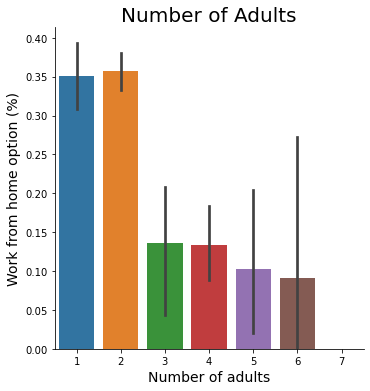

In [53]:
sns.catplot(x="NUMADLT", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Number of adults',fontsize = 14)
plt.title('Number of Adults', fontsize = 20);

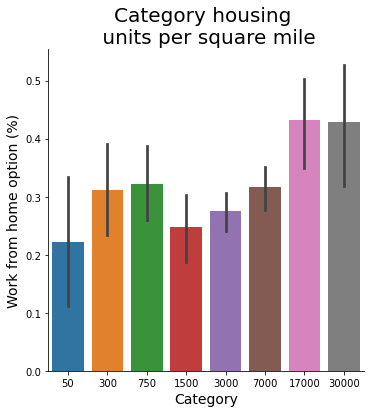

In [55]:
sns.catplot(x="HBRESDN", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Category',fontsize = 14)
plt.title('Category housing \n units per square mile', fontsize = 20);

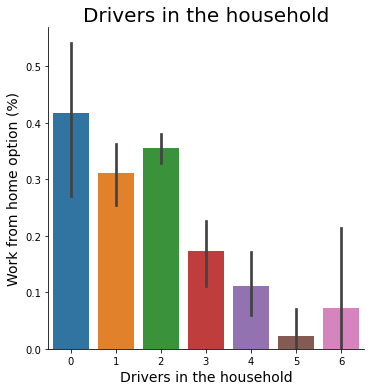

In [56]:
sns.catplot(x="DRVRCNT", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Drivers in the household',fontsize = 14)
plt.title('Drivers in the household', fontsize = 20);

0      111
1      806
2     1188
3      558
4      246
5       89
6       33
7        8
9        3
12       4
Name: HHVEHCNT, dtype: int64

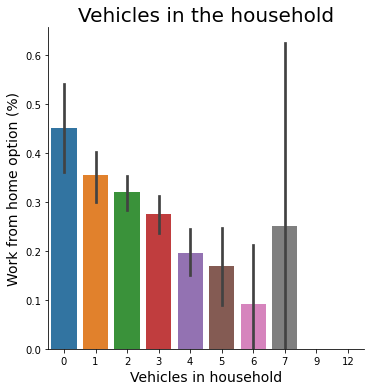

In [57]:
sns.catplot(x="HHVEHCNT", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Vehicles in household',fontsize = 14)
plt.title('Vehicles in the household', fontsize = 20);
workers["HHVEHCNT"].value_counts().sort_index()

In [ ]:
sns.catplot(x="WRKCOUNT", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Vehicles in household',fontsize = 14)
plt.title('Workers in the household', fontsize = 20);

0      111
1      806
2     1188
3      558
4      246
5       89
6       33
7        8
9        3
12       4
Name: HHVEHCNT, dtype: int64

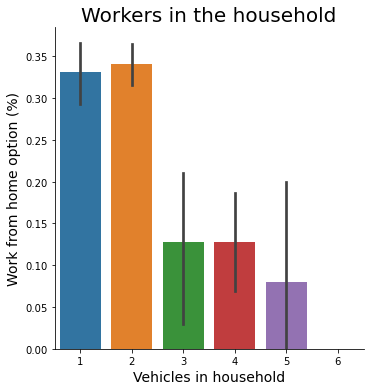

In [139]:
sns.catplot(x="WRKCOUNT", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Vehicles in household',fontsize = 14)
plt.title('Workers in the household', fontsize = 20);
workers["HHVEHCNT"].value_counts().sort_index()

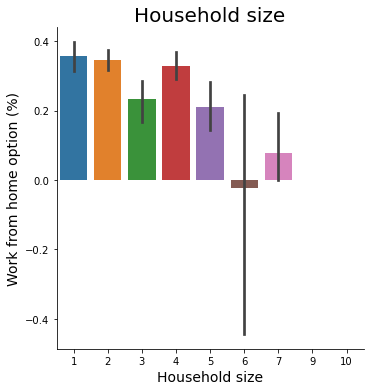

In [144]:
sns.catplot(x="HHSIZE", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Household size',fontsize = 14)
plt.title('Household size', fontsize = 20);

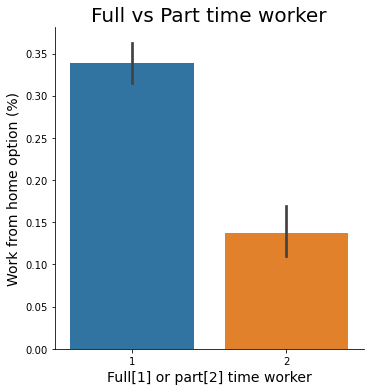

In [58]:
sns.catplot(x="WKFTPT", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Full[1] or part[2] time worker',fontsize = 14)
plt.title('Full vs Part time worker', fontsize = 20);

# 1 is full time, 2 is part time 

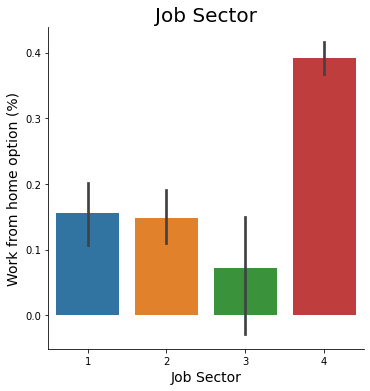

In [59]:
sns.catplot(x="OCCAT", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Job Sector',fontsize = 14)
plt.title('Job Sector', fontsize = 20);

5    1210
4    1008
3     567
2     210
1      51
Name: EDUC, dtype: int64

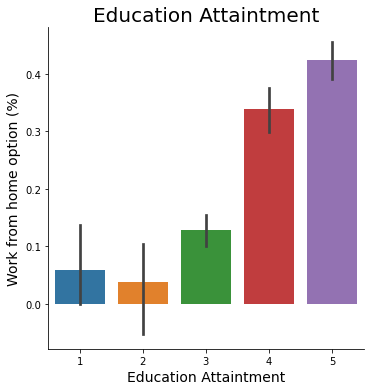

In [60]:
sns.catplot(x="EDUC", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Education Attaintment',fontsize = 14)
plt.title('Education Attaintment', fontsize = 20);
workers.EDUC.value_counts()

-9       1
-8       5
-7      55
 1      18
 2      32
 3      61
 4      89
 5     124
 6     288
 7     331
 8     382
 9     279
 10    543
 11    838
Name: HHFAMINC, dtype: int64

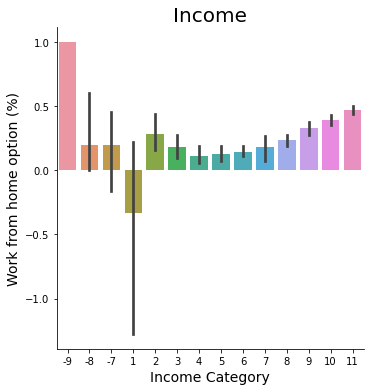

In [62]:
sns.catplot(x="HHFAMINC", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Income Category',fontsize = 14)
plt.title('Income', fontsize = 20);
workers['HHFAMINC'].value_counts().sort_index()


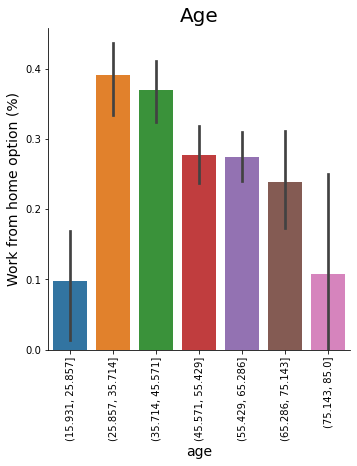

In [67]:
workers['age'] = pd.cut(workers["R_AGE_IMP"], bins = 7)
sns.catplot(x="age", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14)
plt.xlabel('age',fontsize = 14)
plt.title('Age', fontsize = 20)
plt.xticks(rotation = 90);

In [188]:
cat_replace = {1: 2,2:1,3:0,4:1,5:0,6:1,7:0,8:1,9: 2, 10: 2}
workers['fam_type'] = workers['LIF_CYC'].replace(cat_replace)

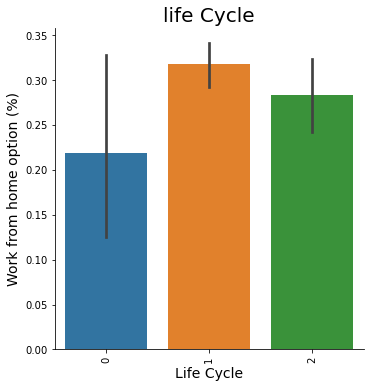

In [189]:
sns.catplot(x='fam_type', y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14)
plt.xlabel('Life Cycle',fontsize = 14)
plt.title('life Cycle', fontsize = 20)
plt.xticks(rotation = 90);

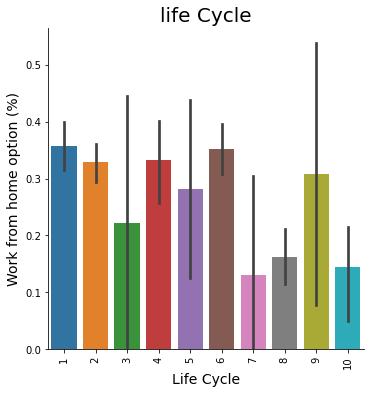

In [180]:
sns.catplot(x='LIF_CYC', y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14)
plt.xlabel('Life Cycle',fontsize = 14)
plt.title('life Cycle', fontsize = 20)
plt.xticks(rotation = 90);

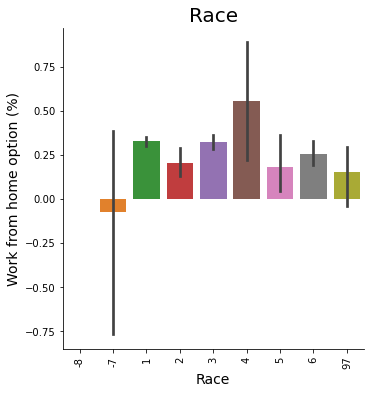

In [181]:
sns.catplot(x='R_RACE', y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14)
plt.xlabel('Race',fontsize = 14)
plt.title('Race', fontsize = 20)
plt.xticks(rotation = 90);

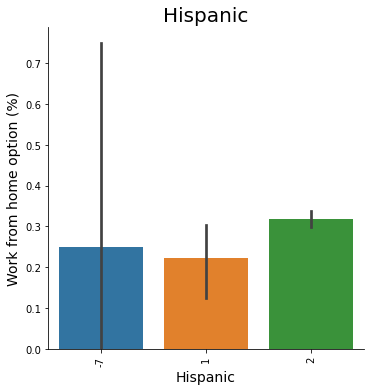

In [182]:

sns.catplot(x='R_HISP', y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14)
plt.xlabel('Hispanic',fontsize = 14)
plt.title('Hispanic', fontsize = 20)
plt.xticks(rotation = 90);

## FREQUENCY OF WORK FROM HOME 
How many days per week a person works from home if WFH is an option

In [4]:
pearson_corr = wfh_workers.corr().loc['WKFMHMXX'].abs().sort_values()
best_corr = pearson_corr[pearson_corr > 0.1].sort_values()
print ('There are {} variables with a absolute pearson correlation greater than 0.1. \n These variables are: {}'.format(len(best_corr), list(best_corr.index)))
best_corr

There are 4 variables with a absolute pearson correlation greater than 0.1. 
 These variables are: ['HHVEHCNT', 'PAYPROF', 'WKFTPT', 'WKFMHMXX']


HHVEHCNT    0.100413
PAYPROF     0.123176
WKFTPT      0.149318
WKFMHMXX    1.000000
Name: WKFMHMXX, dtype: float64

Shortlisted 
 - HHVEHCNT: Household vehicle count
 - WKFTPT: Full time - Part time worker

Dropped variables
  - PAYPROF: Work for pay in previous week 


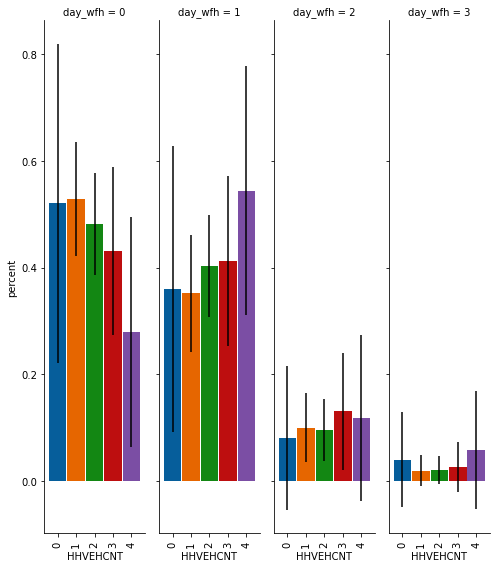

In [37]:
ci = bootsratp(wfh_workers,'HHVEHCNT', 'day_wfh')
ci['ci_len'] = ci.upper_bound - ci.lower_bound

df1 = wfh_workers.groupby("HHVEHCNT")["day_wfh"].value_counts(normalize=True)
df1 = df1.rename('percent')
df1 = pd.concat((df1, ci['ci_len']), axis = 1)
df1 = df1.reset_index()

def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    # print(data)
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax,**kwargs)

colors = ['#065E9B', '#E66600', '#138713', '#BD0E0F', '#7B4EA4']
# colors = ["#4C72B0", "#DD8452", "#55A868", "#C44E52", "#8172B3"]
# colors=["#4C72B0", "#55A868", "#C44E52","#8172B3", "#CCB974", "#64B5CD"]
# colors = [(0., 0., 1.), (0., .5, 0.), (1., 0., 0.), (.75, 0., .75),
#                   (.75, .75, 0.), (0., .75, .75), (0., 0., 0.)]

g = sns.FacetGrid(df1, col="day_wfh")
g.map_dataframe(errplot, "HHVEHCNT", "percent", "ci_len", color= colors, 
 width=0.95, figsize = (7,8))

1    913
0     63
Name: WKFTPT, dtype: int64

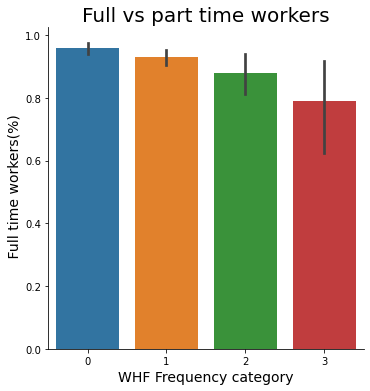

In [52]:
sns.catplot(x="day_wfh", y="WKFTPT", kind="bar", data=wfh_workers)
plt.ylabel(' Full time workers(%)',fontsize = 14);
plt.xlabel('WHF Frequency category',fontsize = 14)
plt.title('Full vs part time workers', fontsize = 20);
wfh_workers["WKFTPT"].value_counts()

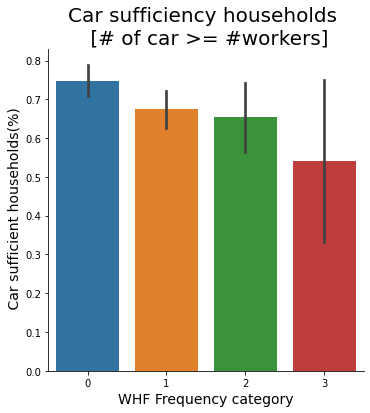

In [51]:
wfh_workers['car_suff']

sns.catplot(x="day_wfh", y='car_suff', kind="bar", data=wfh_workers)
plt.ylabel(' Car sufficient households(%)',fontsize = 14);
plt.xlabel('WHF Frequency category',fontsize = 14)
plt.title('Car sufficiency households \n [# of car >= #workers]', fontsize = 20);

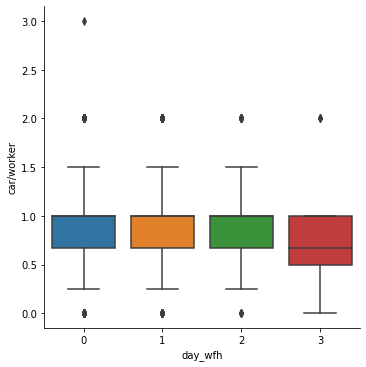

In [47]:
sns.catplot(x="day_wfh", y="car/worker", kind="box",data=wfh_workers)

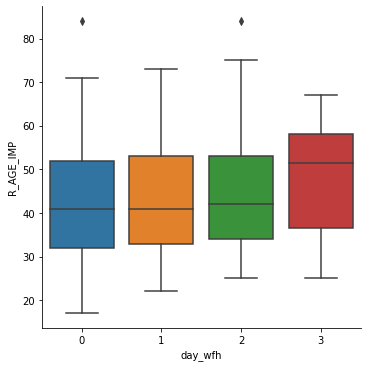

In [48]:
sns.catplot(x="day_wfh", y="R_AGE_IMP", kind="box",data=wfh_workers)

# MODEL Construction - Rates

## Work from home option

In [9]:
## Variable categorization 
df = workers.copy()

# Number of adults in HH 
df['num_adults'] = (df["NUMADLT"] <= 2).astype(int)

# Vehicles in the househols 
df['cars'] = df['HHVEHCNT'].replace({5:4, 6:4, 7:4})

# Job sector 
df['job_sector'] = (df['OCCAT']>=4).astype(int)

#Income
df['income_cat'] = pd.cut(df['HHFAMINC'], bins = [0, 6, 9, 11],
                       labels = [0, 1, 2])

#Density Measure
df['density'] = (df["HBRESDN"] >= 17000).astype(int)

#Drivers 

#Full time workers 
df['WKFTPT'] = df['WKFTPT'].replace({2:0})

#Education 
df['educ'] = pd.cut(df['EDUC'], bins = [0, 3, 4, 5],
                       labels = [0, 1, 2])

#Age 
df['age_cat'] = pd.cut(df['R_AGE_IMP'], bins = [15,25,45, 60,np.inf],
                       labels = [1, 2, 3, 4])

#Car sufficiency
df['car_suff'] = (df["WRKCOUNT"] >= df['HHVEHCNT']).astype(int)                      
df['car_suff'] = (df["WRKCOUNT"] > df['HHVEHCNT']).astype(int) 

#
cat_replace = {1: 2,2:1,3:0,4:1,5:0,6:1,7:0,8:1,9: 2, 10: 2}
df['fam_type'] = df['LIF_CYC'].replace(cat_replace)
# df['car_suff'] = (df["HHSIZE"] > df['HHVEHCNT']).astype(int) 
                    
## Selecting the right variables only and dropping missing values
# vars_ = ['wfh_option', 'num_adults', 'cars', 'job_sector', 
#          'income_cat', 'density', 'DRVRCNT', 'WKFTPT',
#          'educ', 'age_cat']

vars_ = ['wfh_option', 'job_sector', 
         'income_cat', 'age_cat']# 'WRKCOUNT', 'HHSIZE', 'cars']

to_drop = {-9: np.nan, -8: np.nan, -7: np.nan}
pre_drop = df.shape[0]
df = df[vars_].replace(to_drop).dropna(axis = 0)
post_drop = df.shape[0]
pct = (pre_drop-post_drop)/pre_drop * 100
print ('Dropped values {:.2f}%'.format(pct))

Dropped values 2.13%


#### Random Forest 

In [5]:
# from sklearn.ensemble import RandomForestClassifier
# import time
# import numpy as np
# import pandas as pd

# # feature_names = ['educ_cat', 'sector_cat','income_cat', 'age_cat']
# # X = workers[feature_names]
# # Y = workers['WKRMHM']

# y = df['wfh_option']#.pop('wfh_option')
# x = df.drop(columns = ['wfh_option'] )
# feature_names = x.columns

# forest = RandomForestClassifier(random_state=0)
# forest.fit(x, y)

# start_time = time.time()
# importances = forest.feature_importances_
# std = np.std([
#     tree.feature_importances_ for tree in forest.estimators_], axis=0)
# elapsed_time = time.time() - start_time

# print(f"Elapsed time to compute the importances: "
#       f"{elapsed_time:.3f} seconds")


# forest_importances = pd.Series(importances, index=feature_names)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

In [6]:
df.astype(float).corr()

,wfh_option,job_sector,income_cat,age_cat,LIF_CYC,cars,WRKCOUNT,R_RACE,R_HISP,fam_type
wfh_option,1.000000,0.249844,0.246383,-0.053133,-0.117647,-0.145997,-0.109503,-0.037828,0.030251,-0.021894
job_sector,0.249844,1.000000,0.353380,-0.000436,-0.092708,-0.159689,-0.165165,-0.051053,0.098649,-0.037292
income_cat,0.246383,0.353380,1.000000,-0.049798,0.001445,0.134783,0.122646,-0.091705,0.129551,-0.183189
age_cat,-0.053133,-0.000436,-0.049798,1.000000,0.067495,0.007011,-0.212103,-0.042053,0.063643,0.213210
LIF_CYC,-0.117647,-0.092708,0.001445,0.067495,1.000000,0.317987,0.113425,0.001168,0.017330,0.058625
cars,-0.145997,-0.159689,0.134783,0.007011,0.317987,1.000000,0.515109,-0.015586,0.012088,-0.217275
WRKCOUNT,-0.109503,-0.165165,0.122646,-0.212103,0.113425,0.515109,1.000000,-0.012677,-0.040732,-0.396965
R_RACE,-0.037828,-0.051053,-0.091705,-0.042053,0.001168,-0.015586,-0.012677,1.000000,-0.392010,-0.046911
R_HISP,0.030251,0.098649,0.129551,0.063643,0.017330,0.012088,-0.040732,-0.392010,1.000000,0.027869
fam_type,-0.021894,-0.037292,-0.183189,0.213210,0.058625,-0.217275,-0.396965,-0.046911,0.027869,1.000000


### Rates

In [12]:
## Rates 
categories = list(set(vars_) - set(['wfh_option']))
choice = 'wfh_option'
# rates = df.astype(float).groupby(categories)[choice].mean()#value_counts(normalize=True)
# rates.head(50)

ci = bootsratp(df, choice, categories, n = 1000, confidence_level = 0.95, func = 'mean')
# rates_final = pd.concat((rates, ci), axis = 1)
# rates_final
ci

mean  lower_bound  upper_bound
age_cat job_sector income_cat                                    
1       0.0        0           0.000000          NaN          NaN
                   1           0.058091    -0.007322     0.123505
                   2           0.058971    -0.004564     0.122506
        1.0        0           0.234935     0.029332     0.440539
                   1           0.324297     0.174188     0.474406
                   2           0.218413     0.069132     0.367694
2       0.0        0           0.094769     0.045150     0.144388
                   1           0.200990     0.134924     0.267055
                   2           0.343302     0.244426     0.442177
        1.0        0           0.301306     0.217430     0.385182
                   1           0.397043     0.344972     0.449113
                   2           0.548678     0.508647     0.588709
3       0.0        0           0.092044     0.044865     0.139222
                   1           0.101349     0.044810     0.157888
                   2           0.322024     0.212377     0.431670
        1.0        0           0.211178     0.111767     0.310589
                   1           0.246903     0.188999     0.304806
                   2           0.426771     0.379615     0.473928
4       0.0        0           0.089654     0.025963     0.153345
                   1           0.203179     0.095866     0.310493
                   2           0.234075     0.072474     0.395676
        1.0        0           0.126903     0.017198     0.236607
                   1           0.313413     0.198375     0.428451
                   2           0.348978     0.263055     0.434902

## Frequency of working from home
For the rates of the frequency of working from home - No varaibles are selected because the data suggest that once a worker has an option  to work from home, the distribution is pretty uniform across many alternatives 

In [4]:
# wfh_workers['day_wfh'].value_counts(normalize = True)
bootsratp(wfh_workers, 'day_wfh')

,mean,lower_bound,upper_bound
0,0.476590,0.445625,0.507555
1,0.395160,0.364923,0.425397
2,0.103664,0.084686,0.122642
3,0.024586,0.015082,0.034090


## Telecommute today rates 

This is just a summary of all the other tables. It estimates the probability of Telecommute given x, and the other variables. 

# Older code

In [4]:
workers['WKRMHM'] = workers['WKRMHM'].replace({2:0})

# workers['age_cat'] = pd.cut(workers['R_AGE_IMP'], bins = [16,25,40,60, np.inf],
#                        labels = ['16-25', '25-40', '40-60', '+60'])


# workers['income_cat'] = pd.cut(workers['HHFAMINC'], bins = [0, 6, 9, 11],
#                        labels = ['Low', 'middle', 'high'])

# workers['educ_cat'] = pd.cut(workers['EDUC'], bins = [0, 3, 5],
#                        labels = ['Less than collage', 'more than collage'])

# workers['sector_cat'] = pd.cut(workers['OCCAT'], bins = [0, 3, 4],
#                        labels = ['non_p/m/t', 'p/m/t'])


workers['age_cat'] = pd.cut(workers['R_AGE_IMP'], bins = [15,25,40,60, np.inf],
                       labels = [1, 2, 3, 4])

workers['income_cat'] = pd.cut(workers['HHFAMINC'], bins = [0, 6, 9, 11],
                       labels = [1, 2, 3])

workers['educ_cat'] = pd.cut(workers['EDUC'], bins = [0, 3, 5],
                       labels = [1, 2])

workers['sector_cat'] = pd.cut(workers['OCCAT'], bins = [0, 3, 4],
                       labels = [1, 2])


3000     1001
7000      784
1500      427
17000     352
750       196
300       141
30000      91
50         54
Name: HBRESDN, dtype: int64

In [48]:
workers.reset_index(inplace = True)

In [49]:
rates = workers.groupby(['sector_cat','income_cat', 'age_cat']).agg({'index':'count', 'WKRMHM': 'sum'})

In [24]:
rates['index'].sum()

2978

In [50]:
rates

index  WKRMHM
sector_cat income_cat age_cat               
1          1          1           29     0.0
                      2          105    10.0
                      3          162    15.0
                      4           77     7.0
           2          1           51     3.0
                      2          108    23.0
                      3          149    17.0
                      4           54    11.0
           3          1           51     3.0
                      2           76    26.0
                      3           88    29.0
                      4           26     6.0
2          1          1           17     4.0
                      2           90    29.0
                      3           91    19.0
                      4           39     5.0
           2          1           40    13.0
                      2          264   110.0
                      3          258    66.0
                      4           63    19.0
           3          1           32     7.0
                      2          420   235.0
                      3          564   255.0
                      4          124    43.0

## Days working from home 

In [25]:
wfhxx = workers[~workers['WKFMHMXX'].isin([-8, -7, - 1])]

#Create category 
wfhxx['wfhxx_cat'] = pd.cut(wfhxx['WKFMHMXX'], bins = [-1,2,8,15, np.inf],
                       labels = [0, 1, 2, 3])

wfhxx['wfhxx_cat'].value_counts()

0    453
1    379
2     99
3     24
Name: wfhxx_cat, dtype: int64

In [34]:
rates = wfhxx.groupby(['sector_cat','income_cat', 'age_cat', 'wfhxx_cat']).agg({'index':'count'})
rates.shape

(96, 1)

In [46]:
wfhxx

,index,EDUC,R_AGE_IMP,HHFAMINC,R_SEX_IMP,OCCAT,WKRMHM,WKFMHMXX,age_cat,income_cat,educ_cat,sector_cat,wfhxx_cat
1,7,5.0,58.0,6.0,2.0,4.0,1.0,0.0,3,1,2,2,0
2,8,3.0,71.0,7.0,1.0,3.0,1.0,0.0,4,2,1,1,0
3,9,3.0,69.0,7.0,2.0,2.0,1.0,5.0,4,2,1,1,1
6,16,5.0,57.0,7.0,1.0,4.0,1.0,0.0,3,2,2,2,0
9,24,4.0,47.0,10.0,1.0,4.0,1.0,4.0,3,3,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,6743,4.0,30.0,11.0,1.0,4.0,1.0,3.0,2,3,2,2,1
2970,6750,5.0,36.0,11.0,2.0,4.0,1.0,2.0,2,3,2,2,0
2971,6751,5.0,41.0,11.0,1.0,4.0,1.0,6.0,3,3,2,2,1
2975,6763,5.0,46.0,11.0,1.0,4.0,1.0,0.0,3,3,2,2,0


In [47]:
cols = ['age_cat', 'R_SEX_IMP', 'income_cat', 'educ_cat', 'sector_cat', 'wfhxx_cat']
wfhxx[cols].astype(float).corr()

,age_cat,R_SEX_IMP,income_cat,educ_cat,sector_cat,wfhxx_cat
age_cat,1.000000,-0.044372,0.044558,-0.090910,-0.065880,0.045386
R_SEX_IMP,-0.044372,1.000000,-0.052492,-0.017766,-0.088228,0.073954
income_cat,0.044558,-0.052492,1.000000,0.220304,0.213358,-0.025077
educ_cat,-0.090910,-0.017766,0.220304,1.000000,0.313855,-0.041740
sector_cat,-0.065880,-0.088228,0.213358,0.313855,1.000000,-0.060914
wfhxx_cat,0.045386,0.073954,-0.025077,-0.041740,-0.060914,1.000000


In [31]:
rates.head(50)

index
sector_cat income_cat age_cat wfhxx_cat       
1          1          1       0              0
                              1              0
                              2              0
                              3              0
                      2       0              2
                              1              4
                              2              2
                              3              2
                      3       0              6
                              1              4
                              2              2
                              3              3
                      4       0              5
                              1              1
                              2              0
                              3              1
           2          1       0              1
                              1              2
                              2              0
                              3              0
                      2       0             10
                              1              9
                              2              4
                              3              0
                      3       0              7
                              1             10
                              2              0
                              3              0
                      4       0              5
                              1              3
                              2              1
                              3              2
           3          1       0              0
                              1              2
                              2              1
                              3              0
                      2       0             13
                              1             13
                              2              0
                              3              0
                      3       0             14
                              1             11
                              2              4
                              3              0
                      4       0              2
                              1              2
                              2              1
                              3              1
2          1          1       0              2
                              1              1

In [86]:
from sklearn import tree


In [87]:
X = workers[['educ_cat', 'R_SEX_IMP', 'sector_cat','income_cat', 'age_cat']]
Y = workers['WKRMHM']

In [88]:
for cols in X.columns:
    print (X[cols].isnull().sum())

0
0
0
0
0


In [89]:
workers[workers.age_cat.isnull()]

,level_0,index,EDUC,R_AGE_IMP,HHFAMINC,R_SEX_IMP,OCCAT,WKRMHM,WKFMHMXX,age_cat,income_cat,educ_cat,sector_cat


In [106]:
clf = tree.DecisionTreeClassifier(random_state=95688744)
clf = clf.fit(X, Y)

In [107]:
['educ_cat', 'R_SEX_IMP', 'sector_cat','income_cat', 'age_cat']
clf.feature_importances_


array([0.47040076, 0.07526261, 0.07337391, 0.21975226, 0.16121047])

In [95]:
from sklearn.ensemble import RandomForestClassifier
feature_names = ['educ_cat', 'sector_cat','income_cat', 'age_cat']
X = workers[feature_names]
Y = workers['WKRMHM']

forest = RandomForestClassifier(random_state=0)
forest.fit(X, Y)

import time
import numpy as np



start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [111]:
feature_names = ['educ_cat', 'sector_cat','income_cat', 'age_cat']
X = workers[feature_names]
Y = workers['WKRMHM']

forest = RandomForestClassifier(random_state=0)
forest.fit(X, Y)

RandomForestClassifier(random_state=0)

In [112]:
import time
import numpy as np



start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.014 seconds


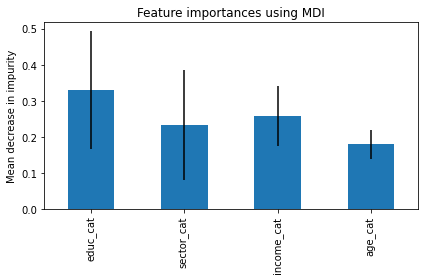

In [113]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [24]:
for col in workers.columns:
    a = (workers[col] == -1).sum()
    print (col, a)

EDUC 0
R_AGE_IMP 0
HHFAMINC 0
R_SEX_IMP 0
OCCAT 0
WKRMHM 0
WKFMHMXX 2067


In [5]:
## Age
df['age_cat'] = pd.cut(df['R_AGE_IMP'], bins = [16,25,40,60, np.inf],
                       labels = ['16-25', '25-40', '40-60', '+60'])

,HOUSEID,ALT_16,ALT_23,ALT_45,BIKE4EX,BIKESHARE,BIKE_DFR,BIKE_GKP,BORNINUS,CARRODE,...,SMPLSRCE,WTHHFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000155,4,2,4,-1,-1,-1,-1,1,1,...,2,120.772451,C,30,3000,1500,1500,30,7000,1500
1,30000450,4,4,4,-1,-1,-1,-1,1,-9,...,1,1041.821764,U,50,17000,7000,5000,50,17000,7000
7,30002934,4,4,4,0,0,-1,4,1,-9,...,2,473.114845,U,80,30000,17000,5000,80,30000,17000
8,30003044,4,3,4,-1,-1,-1,-1,1,1,...,2,652.730553,C,5,1500,300,750,20,3000,750
9,30003044,4,3,4,-1,-1,-1,-1,1,1,...,2,652.730553,C,5,1500,300,750,20,3000,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6754,40789546,4,1,4,-1,-1,-1,-1,2,1,...,2,1321.331419,U,30,7000,3000,3000,20,7000,3000
6758,40789899,1,3,3,1,0,-1,-1,1,-9,...,2,998.737358,U,80,17000,7000,5000,90,17000,7000
6763,40790454,-1,-1,-1,-1,-1,-1,-1,1,-9,...,2,1103.182508,U,70,30000,17000,5000,70,17000,17000
6767,40791490,1,4,4,-1,-1,-1,-1,1,1,...,2,1061.362351,S,5,300,50,75,5,300,50


In [ ]:
# Rate variables 
telecommute_vars = ['EDUC', ]